# CR6 Results Analysis A

## Python Imports

In [1]:
import numpy as np
import pandas as pd
from prettypandas import PrettyPandas
import patsy
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api
from pyomo.environ import *

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

from IPython.display import display, Markdown, HTML

%matplotlib inline
PlotWidth = 6

import warnings
warnings.filterwarnings('ignore')

In [2]:
# helper functions for this notebook

# use SVG for matplotlib-based figures
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

def coded_to_actual(coded_data, actual_lows, actual_highs):
    """Converts a pandas DataFrame from coded units to actuals."""
    actual_data = coded_data.copy()
    for col in actual_data.columns:
        if not (col in actual_highs and col in actual_lows):
            continue
        try:
            # convert continuous variables to their actual value
            actual_data[col] *= 0.5 * (float(actual_highs[col]) - float(actual_lows[col]))
            # don't need to cast to float here, if either are not a float exception will have been thrown
            actual_data[col] += 0.5 * (actual_highs[col] + actual_lows[col])
        except ValueError:
            # assume 2 level categorical
            actual_data[col] = actual_data[col].map({-1: actual_lows[col], 1: actual_highs[col]})
    return actual_data
        
def get_tick_labels(key, lows, highs, units):
    """Returns a list of low/high labels with units (e.g. [8mm, 10mm])"""
    return [str(lows[key]) + units[key], str(highs[key]) + units[key]]

def backward_regression(X, y,
                           threshold_out,
                           verbose=True):
    included=list(X.columns)
    while True:
        changed=False
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
        
    return included

def build_model(X,values,verbose=True):
    X = [sub.replace('alh', 'model.X1') for sub in X]
    X = [sub.replace('aps', 'model.X2') for sub in X]
    X = [sub.replace('aid', 'model.X3') for sub in X]
    X = [sub.replace('arw', 'model.X4') for sub in X]
    X = [sub.replace('awt', 'model.X5') for sub in X]
    X = [sub.replace(':', '*') for sub in X]
    model = str(values[0])
    i=1
    for v in X:
        model  += " + " + str(values[i]) + " * " + v
        i += 1
    if verbose:
        print(model)
    return model

## Process CSV Files

In [3]:

# importing the pandas library
import pandas as pd
  
# reading the csv file using read_csv
# storing the data frame in variable called df
df_cost = pd.read_csv('https://raw.githubusercontent.com/wilsongis/3DP_Experiments/main/Data/cr6_cost_raw.txt', sep='\t')
df_time = pd.read_csv('https://raw.githubusercontent.com/wilsongis/3DP_Experiments/main/Data/cr6_time_raw.txt', sep='\t')
  
# creating a list of column names by
# calling the .columns
list_of_columns_cost = list(df_cost.columns)
list_of_columns_time = list(df_time.columns)
  
# displaying the list of column names
print('List of Cost column names : ', 
      list_of_columns_cost)
print('List of Time column names : ', 
      list_of_columns_time)

List of Cost column names :  ['trial', 'lh', 'ps', 'id', 'rw', 'wt', 'alh', 'aps', 'aid', 'arw', 'awt', 'rep', 'cost']
List of Time column names :  ['trial', 'lh', 'ps', 'id', 'rw', 'wt', 'alh', 'aps', 'aid', 'arw', 'awt', 'rep', 'time']


In [4]:
display((Markdown("### Statistics for Cost")))
df_cost.cost.describe()

### Statistics for Cost

count    80.000000
mean      0.530875
std       0.019500
min       0.480000
25%       0.510000
50%       0.540000
75%       0.540000
max       0.560000
Name: cost, dtype: float64

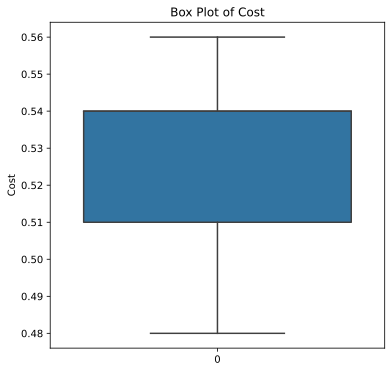

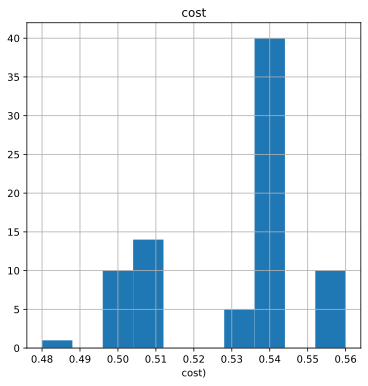

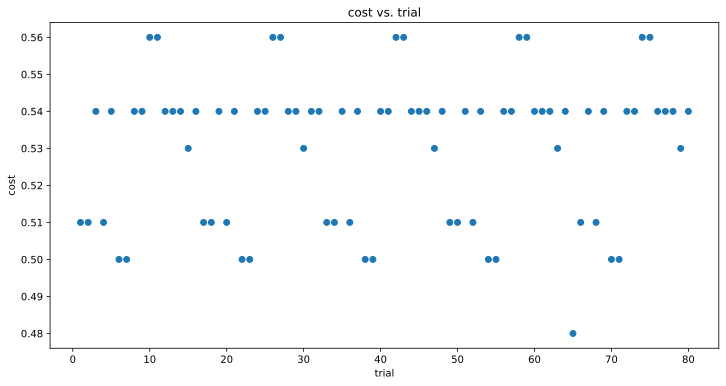

In [5]:
plt.figure(figsize=(PlotWidth, PlotWidth))
sns.boxplot(data=df_cost['cost'])
plt.title('Box Plot of Cost')
plt.ylabel('Cost')
plt.show()

plt.figure(figsize=(PlotWidth, PlotWidth))
df_cost['cost'].hist()
plt.title('cost')
plt.xlabel('cost)')
plt.show()

plt.figure(figsize=(PlotWidth*2, PlotWidth))
plt.scatter(df_cost['trial'], df_cost['cost'])
plt.title('cost vs. trial')
plt.xlabel('trial')
plt.ylabel('cost')
plt.show()

In [6]:
display((Markdown("### Statistics for Time")))
df_time.time.describe()

### Statistics for Time

count       80.00000
mean     12681.40000
std       3360.13591
min       8480.00000
25%       9464.25000
50%      12989.00000
75%      15460.75000
max      18098.00000
Name: time, dtype: float64

plt.figure(figsize=(PlotWidth, PlotWidth))
sns.boxplot(data=df_time['time'])
plt.title('Box Plot of Time')
plt.ylabel('Time')
plt.show()

plt.figure(figsize=(PlotWidth, PlotWidth))
df_time['time'].hist()
plt.title('time')
plt.xlabel('time)')
plt.show()

plt.figure(figsize=(PlotWidth*2, PlotWidth))
plt.scatter(df_time['trial'], df_time['time'])
plt.title('time vs. trial')
plt.xlabel('trial')
plt.ylabel('time')
plt.show()

# Cost Analysis

In [7]:
f = 'cost ~ (alh+aps+aid+arw+awt)**2'
y, X = patsy.dmatrices(f, df_cost, return_type='dataframe')
print(y[:5])
print(X[:5])

   cost
0  0.51
1  0.51
2  0.54
3  0.51
4  0.54
   Intercept   alh   aps   aid  arw  awt  alh:aps  alh:aid  alh:arw  alh:awt  \
0        1.0  0.16  50.0  0.25  0.4  0.8      8.0    0.040    0.064    0.128   
1        1.0  0.28  50.0  0.25  0.4  1.2     14.0    0.070    0.112    0.336   
2        1.0  0.16  60.0  0.25  0.4  1.2      9.6    0.040    0.064    0.192   
3        1.0  0.28  60.0  0.25  0.4  0.8     16.8    0.070    0.112    0.224   
4        1.0  0.16  50.0  0.15  0.4  1.2      8.0    0.024    0.064    0.192   

   aps:aid  aps:arw  aps:awt  aid:arw  aid:awt  arw:awt  
0     12.5     20.0     40.0     0.10     0.20     0.32  
1     12.5     20.0     60.0     0.10     0.30     0.48  
2     15.0     24.0     72.0     0.10     0.30     0.48  
3     15.0     24.0     48.0     0.10     0.20     0.32  
4      7.5     20.0     60.0     0.06     0.18     0.48  


                            OLS Regression Results                            
Dep. Variable:                   cost   R-squared:                       0.971
Model:                            OLS   Adj. R-squared:                  0.964
Method:                 Least Squares   F-statistic:                     141.4
Date:                Sun, 01 Aug 2021   Prob (F-statistic):           4.75e-43
Time:                        02:02:56   Log-Likelihood:                 343.19
No. Observations:                  80   AIC:                            -654.4
Df Residuals:                      64   BIC:                            -616.3
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.3328      0.040      8.322      0.0

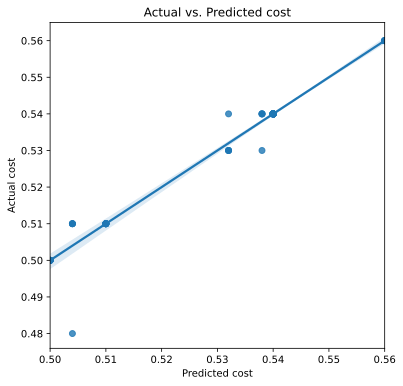

In [8]:

## An intercept is not added by default, so we need to add that here
X = sm.add_constant(X)
results = sm.OLS(y, X).fit()
results.summary()

print(results.summary())

plt.figure(figsize=(PlotWidth, PlotWidth))
sns.regplot(x=results.predict(X), y=y)
plt.xlabel('Predicted cost')
plt.ylabel('Actual cost')
plt.title('Actual vs. Predicted cost')
plt.show()

## Reduced Cost Model

In [9]:
cost_included = backward_regression(X,y,.05)
cost_included.pop(0)
print(cost_included)

Drop alh                            with p-value 0.927017
Drop aid                            with p-value 0.0905131
['aps', 'arw', 'awt', 'alh:aps', 'alh:aid', 'alh:arw', 'alh:awt', 'aps:aid', 'aps:arw', 'aps:awt', 'aid:arw', 'aid:awt', 'arw:awt']


                            OLS Regression Results                            
Dep. Variable:                   cost   R-squared:                       0.969
Model:                            OLS   Adj. R-squared:                  0.963
Method:                 Least Squares   F-statistic:                     160.7
Date:                Sun, 01 Aug 2021   Prob (F-statistic):           1.22e-44
Time:                        02:02:58   Log-Likelihood:                 341.41
No. Observations:                  80   AIC:                            -654.8
Df Residuals:                      66   BIC:                            -621.5
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3006      0.029     10.531      0.0

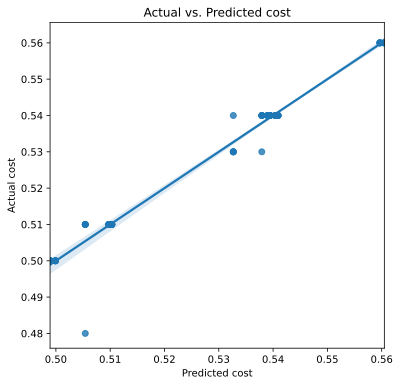

In [10]:
y = df_cost['cost']
#y = df_cost['time']
X = X[cost_included]

## An intercept is not added by default, so we need to add that here
X = sm.add_constant(X)
results = sm.OLS(y, X).fit()
results.summary()

print(results.summary())

plt.figure(figsize=(PlotWidth, PlotWidth))
sns.regplot(x=results.predict(X), y=y)
plt.xlabel('Predicted cost')
plt.ylabel('Actual cost')
plt.title('Actual vs. Predicted cost')
plt.show()

In [11]:
cost_eq = build_model(cost_included,results.params,False)
print("Cost = " + cost_eq)

Cost = 0.30061301677651686 + -0.0014979526099359666 * model.X2 + 0.3541048685686145 * model.X4 + 0.24600811428103486 * model.X5 + 0.003193676289093103 * model.X1*model.X2 + -0.681545835829839 * model.X1*model.X3 + 0.15813870197108404 * model.X1*model.X4 + -0.15310216338152616 * model.X1*model.X5 + 0.008101719131677326 * model.X2*model.X3 + -0.0026250000000000544 * model.X2*model.X4 + 0.0011250000000000322 * model.X2*model.X5 + 0.3961480849887108 * model.X3*model.X4 + -0.4897531916854896 * model.X3*model.X5 + -0.2593750000000006 * model.X4*model.X5


# Time Analysis

In [12]:
f = 'time ~ (alh+aps+aid+arw+awt)**2'
y, X = patsy.dmatrices(f, df_time, return_type='dataframe')
print(y[:5])
print(X[:5])

      time
0  18098.0
1   8741.0
2  14493.0
3  10191.0
4  14914.0
   Intercept   alh   aps   aid  arw  awt  alh:aps  alh:aid  alh:arw  alh:awt  \
0        1.0  0.16  50.0  0.25  0.4  0.8      8.0    0.040    0.064    0.128   
1        1.0  0.28  50.0  0.25  0.4  1.2     14.0    0.070    0.112    0.336   
2        1.0  0.16  60.0  0.25  0.4  1.2      9.6    0.040    0.064    0.192   
3        1.0  0.28  60.0  0.25  0.4  0.8     16.8    0.070    0.112    0.224   
4        1.0  0.16  50.0  0.15  0.4  1.2      8.0    0.024    0.064    0.192   

   aps:aid  aps:arw  aps:awt  aid:arw  aid:awt  arw:awt  
0     12.5     20.0     40.0     0.10     0.20     0.32  
1     12.5     20.0     60.0     0.10     0.30     0.48  
2     15.0     24.0     72.0     0.10     0.30     0.48  
3     15.0     24.0     48.0     0.10     0.20     0.32  
4      7.5     20.0     60.0     0.06     0.18     0.48  


                            OLS Regression Results                            
Dep. Variable:                   time   R-squared:                       0.985
Model:                            OLS   Adj. R-squared:                  0.982
Method:                 Least Squares   F-statistic:                     287.3
Date:                Sun, 01 Aug 2021   Prob (F-statistic):           1.17e-52
Time:                        02:03:01   Log-Likelihood:                -593.61
No. Observations:                  80   AIC:                             1219.
Df Residuals:                      64   BIC:                             1257.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   3.886e+04   4869.801      7.980      0.0

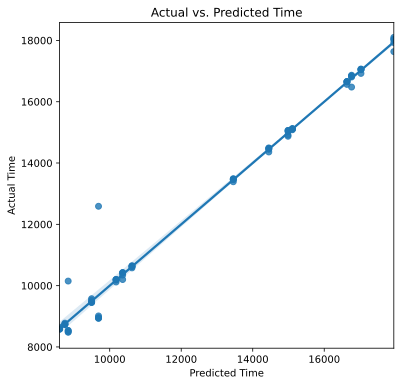

In [13]:
## An intercept is not added by default, so we need to add that here
X = sm.add_constant(X)
results = sm.OLS(y, X).fit()
results.summary()

print(results.summary())

plt.figure(figsize=(PlotWidth, PlotWidth))
sns.regplot(x=results.predict(X), y=y)
plt.xlabel('Predicted Time')
plt.ylabel('Actual Time')
plt.title('Actual vs. Predicted Time')
plt.show()

## Time Reduced Model

In [14]:
time_included = backward_regression(X,y,.05)
time_included.pop(0)
print(time_included)

Drop aps:awt                        with p-value 0.712687
Drop aid                            with p-value 0.63764
Drop arw                            with p-value 0.549529
Drop aid:arw                        with p-value 0.12172
Drop alh:aps                        with p-value 0.0744513
Drop arw:awt                        with p-value 0.0725949
['alh', 'aps', 'awt', 'alh:aid', 'alh:arw', 'alh:awt', 'aps:aid', 'aps:arw', 'aid:awt']


                            OLS Regression Results                            
Dep. Variable:                   time   R-squared:                       0.983
Model:                            OLS   Adj. R-squared:                  0.981
Method:                 Least Squares   F-statistic:                     453.8
Date:                Sun, 01 Aug 2021   Prob (F-statistic):           2.19e-58
Time:                        02:03:02   Log-Likelihood:                -599.26
No. Observations:                  80   AIC:                             1219.
Df Residuals:                      70   BIC:                             1242.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.942e+04   1154.479     34.142      0.0

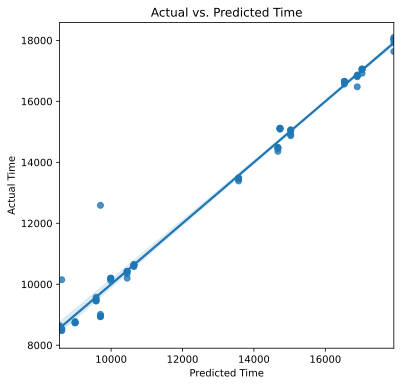

In [15]:
y = df_time['time']
X = X[time_included]

## An intercept is not added by default, so we need to add that here
X = sm.add_constant(X)
results = sm.OLS(y, X).fit()
results.summary()

print(results.summary())

plt.figure(figsize=(PlotWidth, PlotWidth))
sns.regplot(x=results.predict(X), y=y)
plt.xlabel('Predicted Time')
plt.ylabel('Actual Time')
plt.title('Actual vs. Predicted Time')
plt.show()

In [16]:
time_eq = build_model(time_included,results.params,False)
print("Time = " + time_eq)

Time = 39415.87499999855 + -79138.51046393832 * model.X1 + -128.19137670175314 * model.X2 + -8860.849838411767 * model.X5 + -46255.95567867106 * model.X1*model.X3 + 12299.502666120085 * model.X1*model.X4 + 29085.416666666522 * model.X1*model.X5 + 434.58559556786804 * model.X2*model.X3 + -57.717904019688284 * model.X2*model.X4 + -11377.20914127423 * model.X3*model.X5


## Equations

In [17]:
display(Markdown("Cost = "))
print(cost_eq)

print("------")

display(Markdown("Time = "))
print(time_eq)


Cost = 

0.30061301677651686 + -0.0014979526099359666 * model.X2 + 0.3541048685686145 * model.X4 + 0.24600811428103486 * model.X5 + 0.003193676289093103 * model.X1*model.X2 + -0.681545835829839 * model.X1*model.X3 + 0.15813870197108404 * model.X1*model.X4 + -0.15310216338152616 * model.X1*model.X5 + 0.008101719131677326 * model.X2*model.X3 + -0.0026250000000000544 * model.X2*model.X4 + 0.0011250000000000322 * model.X2*model.X5 + 0.3961480849887108 * model.X3*model.X4 + -0.4897531916854896 * model.X3*model.X5 + -0.2593750000000006 * model.X4*model.X5
------


Time = 

39415.87499999855 + -79138.51046393832 * model.X1 + -128.19137670175314 * model.X2 + -8860.849838411767 * model.X5 + -46255.95567867106 * model.X1*model.X3 + 12299.502666120085 * model.X1*model.X4 + 29085.416666666522 * model.X1*model.X5 + 434.58559556786804 * model.X2*model.X3 + -57.717904019688284 * model.X2*model.X4 + -11377.20914127423 * model.X3*model.X5


# Optimization

In [18]:
model = ConcreteModel()

model.X1 = Var(within=NonNegativeReals)
model.X2 = Var(within=NonNegativeReals)
model.X3 = Var(within=NonNegativeReals)
model.X4 = Var(within=NonNegativeReals)
model.X5 = Var(within=NonNegativeReals)

model.C1 = Constraint(expr = model.X1 <= .28)
model.C2 = Constraint(expr = model.X2 <= 60)
model.C3 = Constraint(expr = model.X3 <= .25)
model.C4 = Constraint(expr = model.X4 <= .8)
model.C5 = Constraint(expr = model.X5 <= 1.2)

model.C6 = Constraint(expr = model.X1 >= .16)
model.C7 = Constraint(expr = model.X2 >= 50)
model.C8 = Constraint(expr = model.X3 >= .15)
model.C9 = Constraint(expr = model.X4 >= .4)
model.C10 = Constraint(expr = model.X5 >= .8)

model.f1 = Var()
model.f2 = Var()
model.C_f1 = Constraint(expr = model.f1 == (0.30061301677651686 + -0.0014979526099359666 * model.X2 + 0.3541048685686145 * model.X4 + 0.24600811428103486 * model.X5 + 0.003193676289093103 * model.X1*model.X2 + -0.681545835829839 * model.X1*model.X3 + 0.15813870197108404 * model.X1*model.X4 + -0.15310216338152616 * model.X1*model.X5 + 0.008101719131677326 * model.X2*model.X3 + -0.0026250000000000544 * model.X2*model.X4 + 0.0011250000000000322 * model.X2*model.X5 + 0.3961480849887108 * model.X3*model.X4 + -0.4897531916854896 * model.X3*model.X5 + -0.2593750000000006 * model.X4*model.X5))
model.C_f2 = Constraint(expr = model.f2 == (39415.87499999855 + -79138.51046393832 * model.X1 + -128.19137670175314 * model.X2 + -8860.849838411767 * model.X5 + -46255.95567867106 * model.X1*model.X3 + 12299.502666120085 * model.X1*model.X4 + 29085.416666666522 * model.X1*model.X5 + 434.58559556786804 * model.X2*model.X3 + -57.717904019688284 * model.X2*model.X4 + -11377.20914127423 * model.X3*model.X5))
model.O_f1 = Objective(expr = model.f1, sense=minimize)
model.O_f2 = Objective(expr = model.f2, sense=minimize)

# max f1 separately
# install glpk solver:  sudo apt-get install glpk-utils
model.O_f2.deactivate()
solver = SolverFactory('ipopt')  #'cplex', 'ipopt'
solver.solve(model)

print('( X1 , X2, X3, X4, X5 ) = ( ' + str(value(model.X1)) + ' , ' + str(value(model.X2)) + ' , ' + str(value(model.X3)) + ' , ' + str(value(model.X4)) + ' , ' + str(value(model.X5)) + ' )')
print('f1 = ' + str(value(model.f1)))
print('f2 = ' + str(value(model.f2)))
f2_min = value(model.f2)

# max f2 separately
model.O_f2.activate()
model.O_f1.deactivate()
solver = SolverFactory('ipopt')  #'cplex', 'ipopt'
solver.solve(model)

print('( X1 , X2, X3, X4, X5 ) = ( ' + str(value(model.X1)) + ' , ' + str(value(model.X2)) + ' , ' + str(value(model.X3)) + ' , ' + str(value(model.X4)) + ' , ' + str(value(model.X5)) + ' )')
print('f1 = ' + str(value(model.f1)))
print('f2 = ' + str(value(model.f2)))
f2_max = value(model.f2)

# apply augmented $\epsilon$-Constraint
# max   		f1 + delta*s
# constraint 	f2 - s = e
model.O_f1.activate()
model.O_f2.deactivate()

model.del_component(model.O_f1)
model.del_component(model.O_f2)

model.e = Param(initialize=0, mutable=True)
model.delta = Param(initialize=0.00001)
model.slack = Var(within=NonNegativeReals)
model.O_f1 = Objective(expr = model.f1 + model.delta * model.slack, sense=minimize)
model.C_e = Constraint(expr = model.f2 - model.slack == model.e)

n = 100
step = int((f2_max - f2_min) / n)
steps = list(range(int(f2_min),int(f2_max),step)) + [f2_max]

x1_l, x2_l, x3_l, x4_l, x5_l = [], [], [], [], []
f1_l, f2_l = [], []
for i in steps:
    model.e = i
    solver.solve(model)
    x1_l.append(value(model.X1))
    x2_l.append(value(model.X2))
    x3_l.append(value(model.X3))
    x4_l.append(value(model.X4))
    x5_l.append(value(model.X5))
    f1_l.append(value(model.f1))
    f2_l.append(value(model.f2))
    # print(i, value(model.X1), value(model.X2), value(model.f1), value(model.slack), value(model.f2))



( X1 , X2, X3, X4, X5 ) = ( 0.27999999699979045 , 50.00000021485858 , 0.24999996237920893 , 0.39999999572941514 , 0.8000000173812946 )
f1 = 0.49701939510293697
f2 = 10416.124260969951
( X1 , X2, X3, X4, X5 ) = ( 0.28000000999993935 , 60.000000599972694 , 0.2500000099939384 , 0.8000000096771722 , 1.2000000119993277 )
f1 = 0.53898523398684
f2 = 8557.622612553769
